In [387]:
!ls

README.md	     data_utils.py  new_trade	      sweep.yml
__pycache__	     dec_trade	    old_trade	      train.py
base_config.yml      eda.py	    parser_maker.py   train_copy.py
chan_cur	     etc	    predictions       train_inference.py
chan_wd		     eval_utils.py  prepare.py	      train_loop.py
change_ont_value.py  evaluation.py  preprocessor      training_recorder.py
conf.yml	     graph	    requirements.txt  wandb
conf2.yml	     inference.py   results	      wandb_stuff.py
conf3.yml	     losses.py	    small_trade       whole-in-one.py
configs		     model	    submit.py


In [1]:
%cd ~/project/team/code

/opt/ml/project/team/code


In [144]:
from data_utils import (WOSDataset, load_dataset,
                        seed_everything)
from evaluation import _evaluation

from train_loop import trade_train_loop, submt_train_loop
from inference import trade_inference, sumbt_inference 

from prepare import get_data, get_stuff, get_model

from attrdict import AttrDict

In [145]:
args = AttrDict(
    data_dir= '/opt/ml/input/data/train_dataset',
    ontology_root='/opt/ml/input/data/train_dataset/edit_ontology_metro.json',
    use_domain_slot='basic',
    
    use_small_data=False,
#     hidden_size: 768
#     learning_rate: !!python/float 1e-04

#     num_train_epochs: 30

    train_batch_size=8,
#     eval_batch_size: 8

    model_name_or_path= 'dsksd/bert-ko-small-minimal',
    vocab_size=35000,
#     hidden_dropout_prob: 0.1
#     proj_dim: null
#     teacher_forcing_ratio: 0.5
#     n_gate: 5
    preprocessor='TRADEPreprocessor',
    model_class='TRADE',
    ModelName='TRADE',
    use_convert_ont=False,
)

In [146]:
data, slot_meta, ontology = get_data(args)
train_data, dev_data, _ = load_dataset(data, 0)

In [192]:
domain = '지하철'

found_idx = set()
for i in range(len(train_data)):
    if domain in train_data[i]['domains']:
        found_idx.add(i)
    find_next = False

In [148]:
target = "꿔=바로우"
found = []
found_idx = set()
for i in range(len(train_data)):
    find_next = False
    for dig in train_data[i]['dialogue']:
        if 'state' in dig:
            for st in dig['state']:
                domain, slot, value =  st.split('-')
                if value == target:
                    found.append(dig)
                    find_next = True
                    found_idx.add(i)
                    break
        if find_next:
            break

In [193]:
small_data = [train_data[i] for i in found_idx]

In [194]:
tokenizer, processor, train_features, dev_features = get_stuff(args,
                 small_data, None, slot_meta, ontology)

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


In [195]:
import json
import argparse
import torch
from torch.utils.data import DataLoader, SequentialSampler

tokenized_slot_meta = []
for slot in slot_meta:
    tokenized_slot_meta.append(
        tokenizer.encode(slot.replace("-", " "), add_special_tokens=False)
    )
config = json.load(open(f"results/decoder_long/exp_config.json", "r"))
config = argparse.Namespace(**config)
model =  get_model(config, tokenizer, ontology, slot_meta)
ckpt = torch.load('results/decoder_long/model-best_27.bin', map_location="cpu")
model.load_state_dict(ckpt)

#     wandb_stuff.watch_model(args, model)

train_data2 = WOSDataset(train_features)
train_sampler = SequentialSampler(train_data2)
train_loader = DataLoader(
    train_data2,
    batch_size=args.train_batch_size,
    sampler=train_sampler,
    collate_fn=processor.collate_fn,
)

In [196]:
def postprocess_state(state):
    for i, s in enumerate(state):
        s = s.replace(" : ", ":")
        s = s.replace(" & ", "&")
        s = s.replace(" = ", "=")
        s = s.replace("( ", "(")
        s = s.replace(" )", ")")
        state[i] = s.replace(" , ", ", ")
    return state

In [197]:
device = torch.device('cuda')
model.to(device)
print()

In [198]:
from tqdm.auto import tqdm
from training_recorder import RunningLossRecorder
from torch.cuda.amp import autocast
use_amp = False

model.eval()
predictions = {}
no_post = {}
eval_loader = train_loader
pbar = tqdm(eval_loader, total=len(eval_loader))
loss_recorder = RunningLossRecorder(len(eval_loader))
cnt = 0
for batch in pbar:
    input_ids, segment_ids, input_masks, gating_ids, target_ids, guids = [
        b.to(torch.device(device)) if not isinstance(b, list) else b for b in batch
    ]

    with torch.no_grad():
        with autocast(enabled=use_amp):
            o, g = model(input_ids, segment_ids, input_masks, 9)

#         if loss_fnc is not None:
#             with autocast(enabled=use_amp):
#                 loss_dict = loss_fnc(o, g, target_ids, gating_ids)

#             cpu_loss_dict = {k:v.item() for k, v in loss_dict.items()}
#             loss_recorder.add(cpu_loss_dict)

        _, generated_ids = o.max(-1)
        _, gated_ids = g.max(-1)


    for guid, gate, gen in zip(guids, gated_ids.tolist(), generated_ids.tolist()):
        prediction = processor.recover_state(gate, gen)
        no_post[guid] = prediction
        prediction = postprocess_state(prediction)
        predictions[guid] = prediction

    cnt += 1
#     if cnt == 1:
#         break
    
pbar.close()


In [199]:
from data_utils import get_examples_from_dialogues
user_first = False
dialogue_level = False
processor_kwargs = AttrDict()
    
train_examples = get_examples_from_dialogues(
    small_data, user_first=user_first, dialogue_level=dialogue_level, which='train'
)

In [227]:
idx = 1200
ln = len(train_examples)

In [231]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
while idx < ln:
    datum = train_examples[idx]
    idx += 1
    guid = datum.guid
    answer = set(datum.label)
    pred = set(predictions[guid])
    if True: #set(datum.label) != set(predictions[guid]):
        print(f'dialogue {idx}')
        for i in range(len(datum.context_turns)//2):
            print(f'SYS: {datum.context_turns[2*i]}')
            print(f'USR: {datum.context_turns[2*i + 1]}')

        print()
        print(f'SYS: {datum.current_turn[0]}')
        print(f'USR: {datum.current_turn[1]}')
        
        tab = '\t'
        print(f'MISSED: {tab.join(sorted(answer - pred))}')
        print(f'WRONG : {tab.join(sorted(pred - answer))}')
        print(f'CORREC: ')
        pp.pprint(sorted(answer & pred))
        break
 

dialogue 1511
SYS: 
USR: 여보세요? 네 서울에 왔는데 모텔예약을 도와주실수 있을까요?
SYS: 네 반갑습니다. 원하시는 지역과 가격대를 말씀해주시면 안내 도와드리겠습니다.
USR: 지역은 서울 북쪽이 좋을것 같습니다. 그리고 가격은 상관없습니다.
SYS: 말씀하신 조건에 많은 숙소가 나오는데요. 혹시 추가하실 조건이 있으신가요?
USR: 음 제가 차가없어서 도보가 가능하면 좋겠습니다.
SYS: 네 종로구에 위치한 화이트 모텔이 평점이 비교적 높습니다. 이곳으로 예약하시겠습니까?
USR: 음 좋을것 같아요. 그럼 월요일부터 3일이고 3명으로 예약해주세요.
SYS: 네 예약되었습니다.
USR: 지하철역에서 숙소가 몇분거리에 있나요?
SYS: 종각역에서 도보로 3분거리입니다.
USR: 아 좋네요. 그리고 관광지정보를 알았으면 하는데 일단 서울 북쪽에 역사적으로 의미가 있는 랜드마크가 뭐가 있을까요?
SYS: 네 그 지역에 가장 유명한 랜드마크로는 세종대왕 동상이 있습니다. 
USR: 아 괜찮다고 들어본것 같네요. 거기가 도보가 가능한곳이죠? 그리고 지하철역이 뭐가 있어요?
SYS: 도보로 가능하고요. 가장 가까운 지하철역은 광화문역이 있습니다.
USR: 네 알겠습니다. 그럼 숙소근처의 지하철역에서 관광지 근처의 지하철역에 가려면 어떻게 타야하나요?

SYS: 네 1호선 종각역에서 탑승하시고 종로3가역에서 5호선으로 환승하신후 광화문역에서 하차하시면 됩니다.
USR: 예 잘 안내해주셔서 감사합니다. 안녕히 계세요.
MISSED: 
WRONG : 
CORREC: 
[   '관광-역사적-yes',
    '관광-이름-세종대왕 동상',
    '관광-종류-랜드마크',
    '관광-지역-서울 북쪽',
    '숙소-가격대-dontcare',
    '숙소-도보 가능-yes',
    '숙소-예약 기간-3',
    '숙소-예약 명수-3',
    '숙소-예약 요일-월요일',
    '숙소-이름-화이트모텔',
    '숙소-종류-모텔',
    '숙소-지

In [46]:
set(datum.label) == set(predictions[guid])

True

In [410]:
small_data

[{'dialogue_idx': 'red-glade-4950:식당_택시_10',
  'domains': ['식당', '택시'],
  'dialogue': [{'role': 'user',
    'text': '안녕하세요. 서울 동쪽에 있는 한식당을 찾고 있어요. 좀 저렴하면서도 야외석이 있는 곳으로요.',
    'state': ['식당-가격대-저렴', '식당-지역-서울 동쪽', '식당-종류-한식당', '식당-야외석 유무-yes']},
   {'role': 'sys', 'text': '해당 조건으로 검색되는 식당은 없는데 야외석이 없는곳으로도 알아봐 드릴까요?'},
   {'role': 'user',
    'text': '그럼 그렇게 해주세요.',
    'state': ['식당-가격대-저렴', '식당-지역-서울 동쪽', '식당-종류-한식당', '식당-야외석 유무-no']},
   {'role': 'sys', 'text': '야외석이 없는곳으로는 두부두부두부라는 순두부찌개 전문점이 있습니다.'},
   {'role': 'user',
    'text': '거기로 그럼 월요일 1시로 7명 예약해 주세요.',
    'state': ['식당-가격대-저렴',
     '식당-지역-서울 동쪽',
     '식당-종류-한식당',
     '식당-야외석 유무-no',
     '식당-예약 요일-월요일',
     '식당-예약 시간-13:00',
     '식당-예약 명수-7',
     '식당-이름-두부두부두부']},
   {'role': 'sys', 'text': '네. 말씀하신대로 식당 예약 해 드렸습니다.'},
   {'role': 'user',
    'text': '순두부찌개 전문점이라고 하셨는데 그럼 대표 메뉴가 순두부찌개 인가요?',
    'state': ['식당-가격대-저렴',
     '식당-지역-서울 동쪽',
     '식당-종류-한식당',
     '식당-야외석 유무-no',
     '식당-예약 요일-월요일',
     '식당-예약 시간-13:0

In [318]:
predictions

{'red-glade-4950:식당_택시_10-0': ['식당-가격대-저렴',
  '식당-야외석 유무-yes',
  '식당-종류-한식당',
  '식당-지역-서울 동쪽'],
 'red-glade-4950:식당_택시_10-1': ['식당-가격대-저렴',
  '식당-야외석 유무-no',
  '식당-종류-한식당',
  '식당-지역-서울 동쪽'],
 'red-glade-4950:식당_택시_10-2': ['식당-가격대-저렴',
  '식당-야외석 유무-no',
  '식당-예약 명수-7',
  '식당-예약 시간-03:00',
  '식당-예약 요일-월요일',
  '식당-이름-두부두부두부',
  '식당-종류-한식당',
  '식당-지역-서울 동쪽'],
 'red-glade-4950:식당_택시_10-3': ['식당-가격대-저렴',
  '식당-야외석 유무-no',
  '식당-예약 명수-7',
  '식당-예약 시간-03:00',
  '식당-예약 요일-월요일',
  '식당-이름-두부두부두부',
  '식당-종류-한식당',
  '식당-지역-서울 동쪽'],
 'red-glade-4950:식당_택시_10-4': ['식당-가격대-저렴',
  '식당-야외석 유무-no',
  '식당-예약 명수-7',
  '식당-예약 시간-03:00',
  '식당-예약 요일-월요일',
  '식당-이름-두부두부두부',
  '식당-종류-한식당',
  '식당-지역-서울 동쪽'],
 'red-glade-4950:식당_택시_10-5': ['식당-가격대-저렴',
  '식당-야외석 유무-no',
  '식당-예약 명수-7',
  '식당-예약 시간-03:00',
  '식당-예약 요일-월요일',
  '식당-이름-두부두부두부',
  '식당-종류-한식당',
  '식당-지역-서울 동쪽',
  '택시-도착지-밀수업자',
  '택시-출발 시간-05:30',
  '택시-출발지-진 하우스'],
 'red-glade-4950:식당_택시_10-6': ['식당-가격대-저렴',
  '식당-야외석 유무-no',
  '식당-예약 명수-7',
  '식당-예약

In [195]:
x = o[0, 30].max(-1)[1]
tokenizer.decode(x)

'꿔 = 바로우 [SEP] [SEP]다 [SEP]다'

In [214]:
tokenizer.decode(4180)

'# # 우'

In [238]:
mod_tokenizer.

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [228]:
inc = mod_tokenizer.encode('꿔=바로우', add_special_tokens=False)
mod_tokenizer.decode(inc, skip_special_tokens=True)

'꿔 = 바로우'

In [235]:
mod_tokenizer.add_tokens('=')
r = mod_tokenizer.encode('a=', add_special_tokens=False)
mod_tokenizer.decode(r, skip_special_tokens=True)

'a ='

In [198]:
token_id_list = []
for id_ in x:
    if id_ in tokenizer.all_special_ids:
        break

    token_id_list.append(id_)
value = tokenizer.decode(token_id_list, skip_special_tokens=True)
value

'꿔 = 바로우'

In [210]:
tokenizer.decode(3)

'[ S E P ]'

In [206]:
y = o[6, 44].max(-1)[1]
print(y)
tokenizer.decode(y)

tensor([ 6244,  6784, 15957,     3,  4080,  4717,     3,  4080,  4717])


'한국 전쟁 기념관 [SEP]초밥 [SEP]초밥'

In [189]:
o[0, 30].shape

torch.Size([9, 35000])

In [115]:
filt = ['sweet-sunset-1557:식당_택시_10', 'solitary-poetry-5418:관광_식당_택시_12', 'throbbing-bonus-3914:식당_관광_숙소_9', 
           'icy-brook-1323:식당_관광_택시_13', 'aged-lake-2675:식당_2']

In [174]:
ix = 0

In [177]:
print(ix, predictions[f'{wrong[4]["dialogue_idx"]}-{ix}'])
ix += 1

2 ['식당-가격대-적당', '식당-예약 명수-2', '식당-예약 시간-02:20', '식당-예약 요일-목요일', '식당-이름-가지가지차이나', '식당-종류-중식당', '식당-지역-서울 남쪽']


In [118]:
wrong = [x for x in small_data if x['dialogue_idx'] in filt]
len(wrong)

5

In [56]:
import math
import os.path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from transformers import AutoModelForPreTraining, AutoConfig, AutoTokenizer

# https://github.com/CyberZHG/torch-position-embedding
from torch_position_embedding import PositionEmbedding 

class AutoForUtteranceEncoding(nn.Module):
    def __init__(self, config, model):
        super().__init__()
        self.config = config
        self.base = model

    def forward(self, input_ids, token_type_ids, attention_mask):
        return self.base(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_attentions=False,
            output_hidden_states=True,
            return_dict=True,
        )
    
    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *model_args, **kwargs):
        config = AutoConfig.from_pretrained(pretrained_model_name_or_path, **kwargs)
        model = AutoModelForPreTraining.from_pretrained(pretrained_model_name_or_path, *model_args, **kwargs)
        ret = cls(config, model)
        return ret

In [53]:
model_name = 'dsksd/bert-ko-small-minimal'
a = AutoForUtteranceEncoding.from_pretrained(model_name)

In [54]:
def tokenize_ontology(ontology, tokenizer, max_seq_length):
    slot_types = []
    slot_values = []
    
    for k in sorted(ontology):
        v = ontology[k]
        tokens = tokenizer.encode(k)
        if len(tokens) < max_seq_length:
            gap = max_seq_length - len(tokens)
            tokens.extend([tokenizer.pad_token_id] * gap)
        if len(tokens) > max_seq_length:
            tokens = tokens[:max_seq_length]
        slot_types.append(tokens)
        slot_value = []
        for vv in v:
            tokens = tokenizer.encode(vv)
            if len(tokens) < max_seq_length:
                gap = max_seq_length - len(tokens)
                tokens.extend([tokenizer.pad_token_id] * gap)
            if len(tokens) > max_seq_length:
                tokens = tokens[:max_seq_length]
            slot_value.append(tokens)
        slot_values.append(torch.LongTensor(slot_value))
    return torch.LongTensor(slot_types), slot_values

In [58]:
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [219]:
small_ont = {'식당-예약 시간':ontology['식당-예약 시간']}

In [284]:
word_times = []
for i in range(24):
    for j in range(60):
        word_times.append(f'시간 {i:02}시 {j:02}분')
mod_ont = {'식당-예약 시간':['none','dontcare'] + word_times}

In [285]:
b = tokenize_ontology(mod_ont, tokenizer, 30)

In [286]:
slot_values = b[1][0]

In [287]:
(slot_values > 0).sum(-1).max()

tensor(7)

In [288]:
slot_values.shape

torch.Size([1442, 30])

In [293]:
bef = []
res = []
for idx in tqdm(range(slot_values.size(0)-1)):
    labels = slot_values[idx:idx+2, :12]
    type_ids =torch.zeros(labels.size(), dtype=torch.long)
    label_mask = labels > 0
    
    dim = a(labels, type_ids, label_mask)[0][:, 0, :].unsqueeze(0)
    
    dist = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=False)
    distance = dist(dim[:, 0], dim[:, 1])
    res.append(distance)

In [290]:
bef = []
for i in tqdm(range((slot_values.size(0)-2)//10)):
    labels = slot_values[10*idx:10*idx+10, :12]
    type_ids =torch.zeros(labels.size(), dtype=torch.long)
    label_mask = labels > 0
    
    dim = a(labels, type_ids, label_mask)[0][:, 0, :]
    bef.append(dim.detach().numpy())

In [291]:
beff = np.concatenate(bef)

In [199]:
dim.shape

torch.Size([1, 2, 35000])

In [294]:
clocks4 = res[2:]

In [187]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# 시간

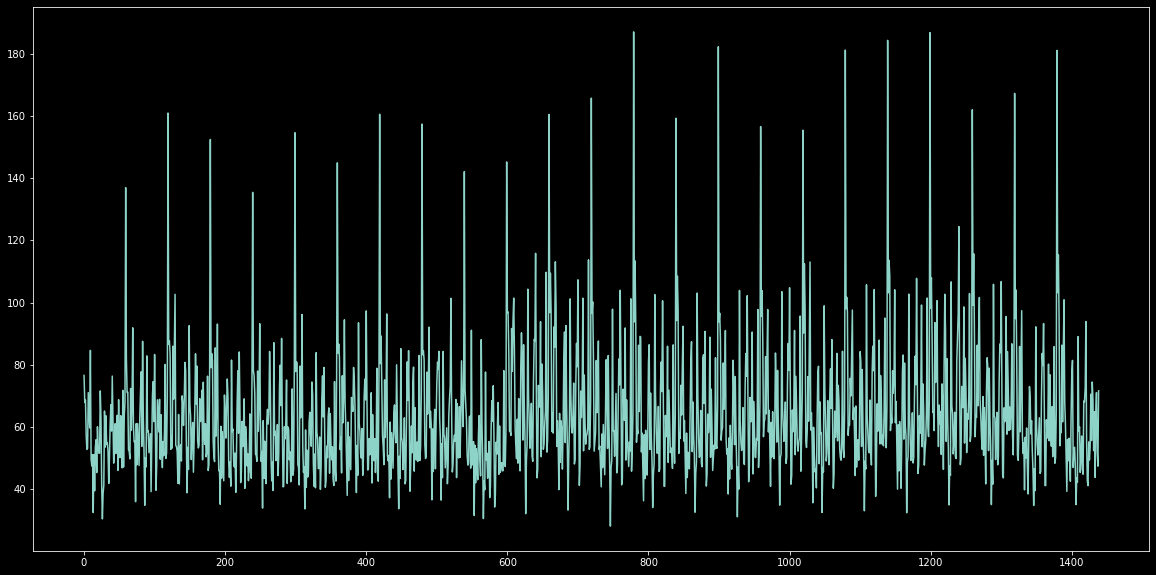

In [298]:
fig = plt.figure(figsize=(20, 10))
plt.plot(clocks4)

# MOD_ONT 2

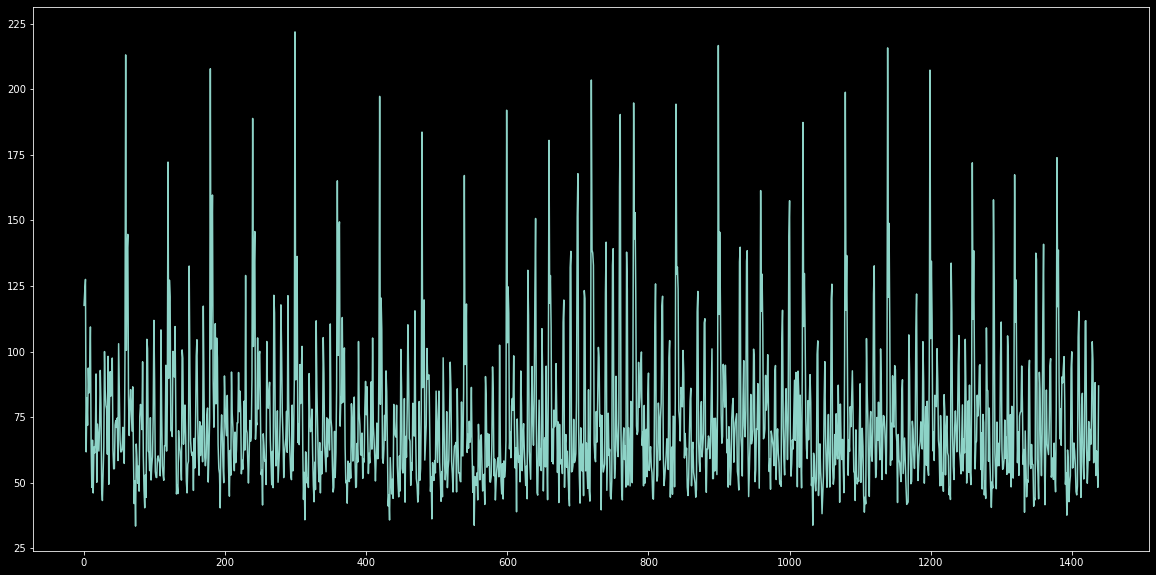

In [191]:
fig = plt.figure(figsize=(20, 10))
plt.plot(clocks3)

# MOD ONT

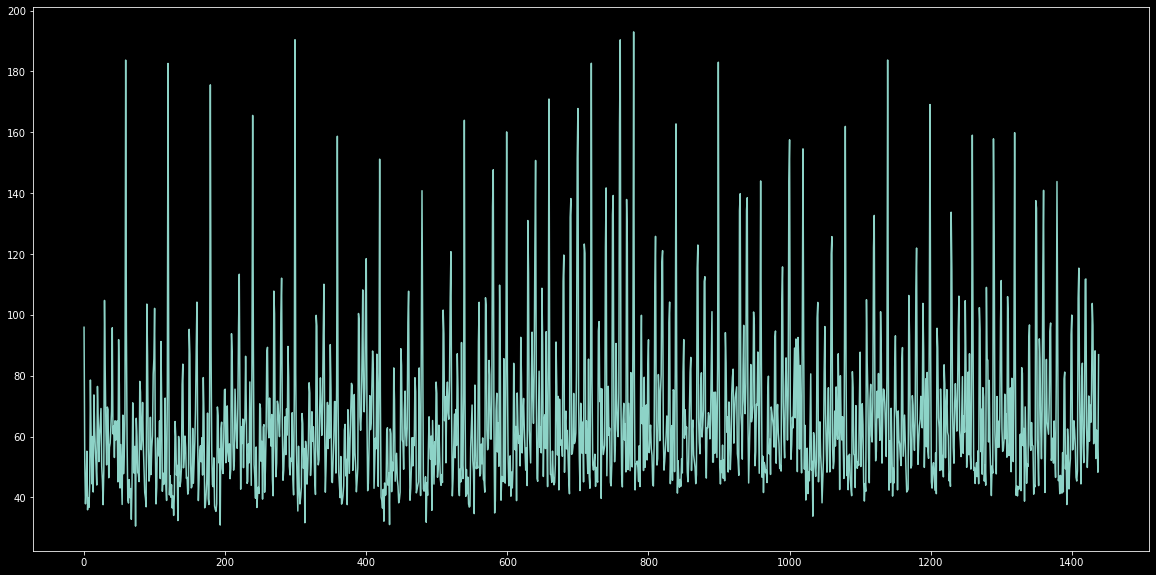

In [175]:
fig = plt.figure(figsize=(20, 10))
plt.plot(clocks2)

# ORIGINAL

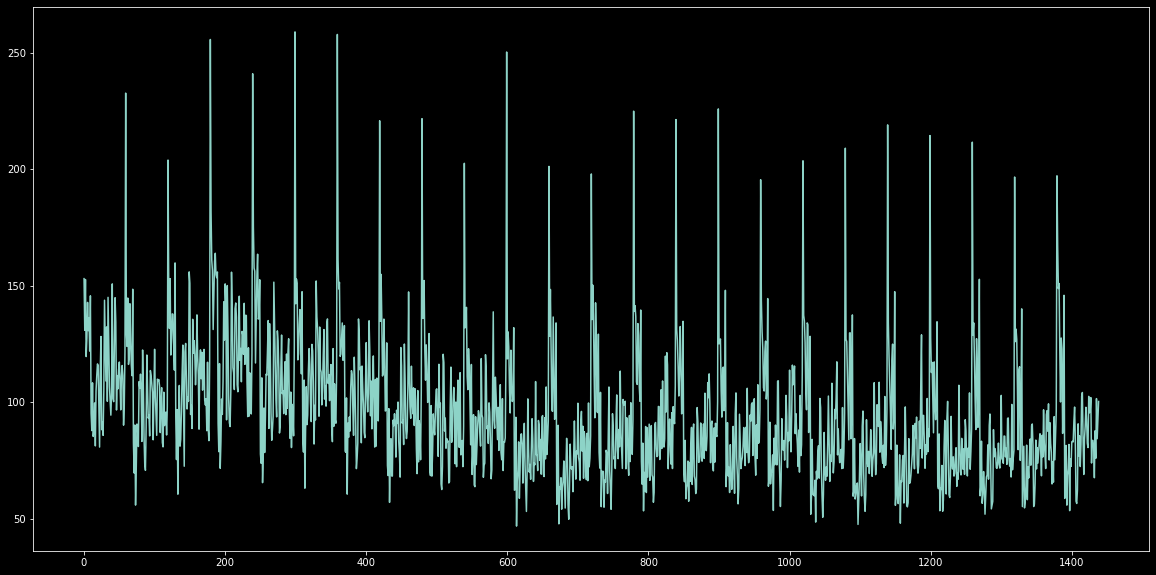

In [149]:
fig = plt.figure(figsize=(20, 10))
plt.plot(clocks)

In [154]:
clocks3 = [x.item() for x in clocks3]

In [192]:
def clean(aa):
    return np.array([x.item() for x in aa])

In [195]:
c3 = clean(clocks3)

In [159]:
np.where(clocks > 200)

(array([  59,  119,  179,  239,  299,  359,  419,  479,  539,  599,  659,
         779,  839,  899, 1019, 1079, 1139, 1199, 1259]),)

In [190]:
from sklearn.decomposition import PCA

In [224]:
pca = PCA(n_components=2)
pca.fit(beff)

PCA(n_components=2)

# 00:22

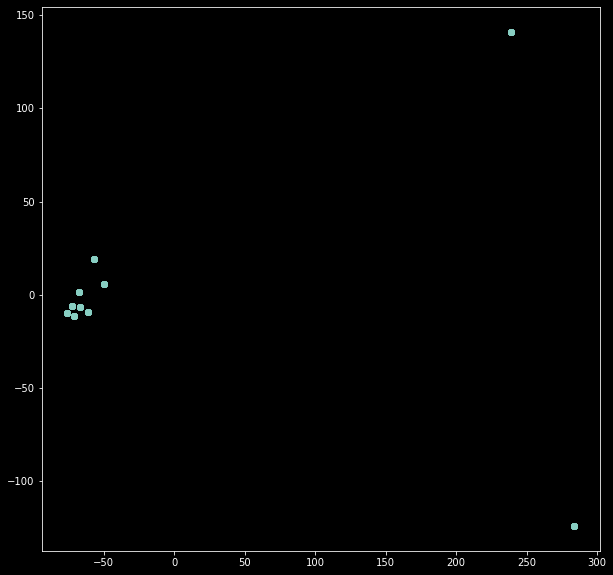

In [228]:
fig = plt.figure(figsize=(10, 10))
beff = pca.transform(beff)
plt.scatter(beff[:, 0], beff[:, 1], alpha=0.2)

# 00시 00분

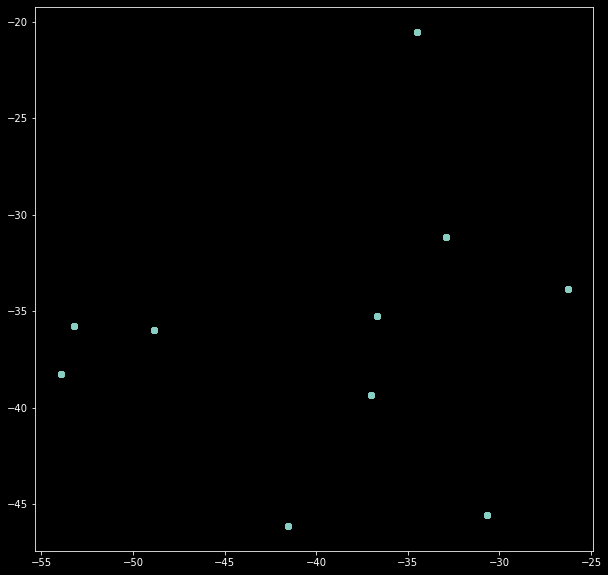

In [237]:
fig = plt.figure(figsize=(10, 10))
beff = pca.transform(beff)
plt.scatter(beff[:, 0], beff[:, 1], alpha=0.2)

# 2시 1분

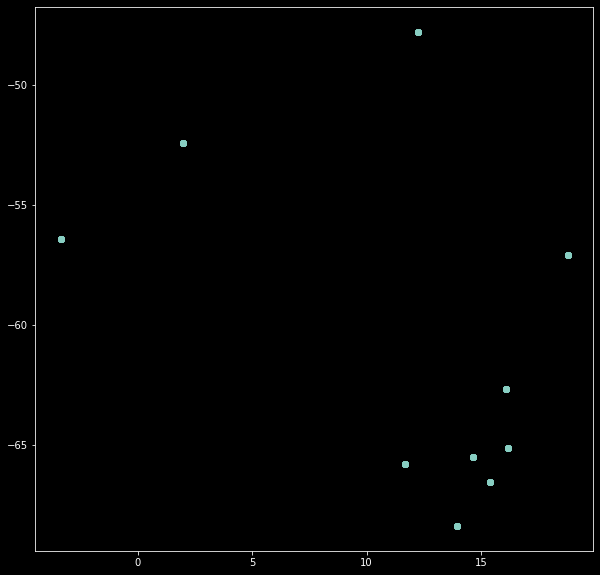

In [248]:
fig = plt.figure(figsize=(10, 10))
# beff = pca.transform(beff)
plt.scatter(beff[:, 0], beff[:, 1], alpha=0.1)

In [253]:
beff.sort()
beff

array([[-52.42849  ,   1.9567125],
       [-56.417137 ,  -3.380082 ],
       [-47.786045 ,  12.226275 ],
       ...,
       [-68.392006 ,  13.97207  ],
       [-66.573395 ,  15.381513 ],
       [-65.81497  ,  11.696232 ]], dtype=float32)

# 2시 1분 02:01

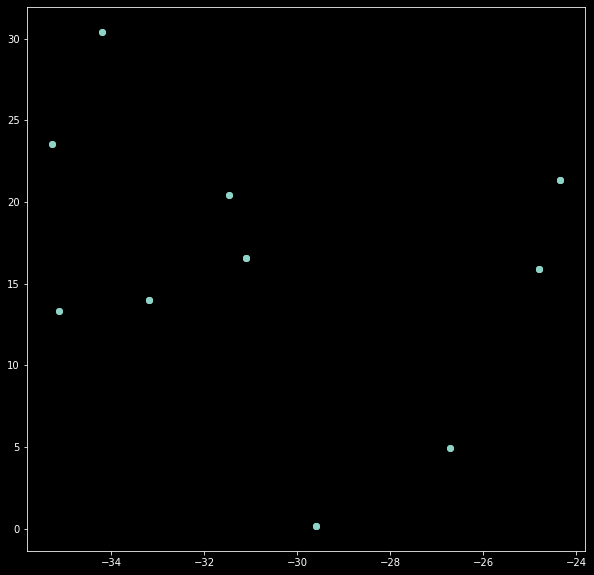

In [305]:
fig = plt.figure(figsize=(10, 10))
# beff = pca.transform(beff)
plt.scatter(beff[::59, 0], beff[::59, 1], alpha=1)

In [ ]:
beff[:200, 1].노